<a href="https://colab.research.google.com/github/arrx08/jleague_elo/blob/main/ELO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=e000415b8af2f2bc461bffdfe6d9bcfbf23376e096a1abf85ceef8c798306faf
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


In [ ]:
import pandas as pd
import numpy as np

# 2024年J1の結果のURL
url = "https://data.j-league.or.jp/SFMS01/search?competition_years=2024&competition_frame_ids=1&competition_ids=589&tv_relay_station_name="


data = pd.read_html(url)
retrieved_df = data[0]
retrieved_df.head()

,年度,大会,節,試合日,K/O時刻,ホーム,スコア,アウェイ,スタジアム,入場者数,インターネット中継・TV放送
0,2024,Ｊ１,第１節第１日,02/23(金・祝),14:06,広島,2-0,浦和,Ｅピース,27545,ＤＡＺＮ／ＮＨＫ総合
1,2024,Ｊ１,第１節第１日,02/23(金・祝),18:03,名古屋,0-3,鹿島,豊田ス,36933,ＤＡＺＮ
2,2024,Ｊ１,第１節第２日,02/24(土),13:03,磐田,0-2,神戸,ヤマハ,14778,ＤＡＺＮ／静岡放送
3,2024,Ｊ１,第１節第２日,02/24(土),14:04,福岡,0-0,札幌,ベススタ,9445,ＤＡＺＮ／ＮＨＫ福岡／ＮＨＫ札幌
4,2024,Ｊ１,第１節第２日,02/24(土),14:05,鳥栖,1-2,新潟,駅スタ,9610,ＤＡＺＮ／ＮＨＫ新潟／サガテレビ


In [ ]:
df = pd.DataFrame()

df['date'] = pd.to_datetime(retrieved_df['年度'].astype(str) + '/' + retrieved_df['試合日'].str.extract(r'(\d+/\d+)')[0])
df['home_team'] = retrieved_df['ホーム']
df['away_team'] = retrieved_df['アウェイ']
df[['home_score', 'away_score']] = retrieved_df['スコア'].str.split('-', expand=True).astype(int)

df['home_point'] = df.apply(
    lambda x: 3 if x['home_score'] > x['away_score'] else (1 if x['home_score'] == x['away_score'] else 0),
    axis=1
)

df['away_point'] = df.apply(
    lambda x: 3 if x['home_score'] < x['away_score'] else (1 if x['home_score'] == x['away_score'] else 0),
    axis=1
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        380 non-null    datetime64[ns]
 1   home_team   380 non-null    object        
 2   away_team   380 non-null    object        
 3   home_score  380 non-null    int64         
 4   away_score  380 non-null    int64         
 5   home_point  380 non-null    int64         
 6   away_point  380 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 20.9+ KB


In [ ]:
# チームのリスト
teams = df['home_team'].unique()
teams

array(['広島', '名古屋', '磐田', '福岡', '鳥栖', '町田', 'Ｃ大阪', '湘南', '柏', '東京Ｖ',
       '横浜FM', '川崎Ｆ', '神戸', '京都', '鹿島', 'Ｇ大阪', 'FC東京', '浦和', '新潟', '札幌'],
      dtype=object)

In [ ]:
def calculate_elo(home_elo, away_elo, home_score, away_score, k=20, home_advantage=50):
  """
  Soccer-specified ELO
  """
  # ホームアドバンテージ反映
  home_elo_adjusted = home_elo + home_advantage

  # 期待勝率
  expected_home = 1 / (1 + 10 ** ((away_elo - home_elo_adjusted) / 400))
  expected_away = 1 - expected_home

  # 得失点差をELOに反映
  goal_difference = abs(home_score - away_score)
  # margin_of_victory = np.log(max(goal_difference, 1) + 1) * (2.2 / (expected_home if home_score > away_score else expected_away))
  margin_of_victory = 1

  # 試合結果の反映
  if home_score > away_score:
    actual_home, actual_away = 1, 0
  elif home_score < away_score:
    actual_home, actual_away = 0, 1
  else: #引分けは0.5ずつ
    actual_home, actual_away = 0.5, 0.5

  # 新しいELOの計算
  new_home_elo = home_elo + k * margin_of_victory * (actual_home - expected_home)
  new_away_elo = away_elo + k * margin_of_victory * (actual_away - expected_away)

  return new_home_elo, new_away_elo


In [ ]:
# ELOの初期値
initial_elo_score = 1500

# チームごとのELOスコア(最新値)
elo_scores = {}

for team in teams:
  elo_scores[team] = initial_elo_score

# チームごとのELOスコアの推移(推移なのでリストに)
elo_history = {team: [elo_scores[team]] for team in elo_scores.keys()}

print(elo_scores)
print(elo_history)

{'広島': 1500, '名古屋': 1500, '磐田': 1500, '福岡': 1500, '鳥栖': 1500, '町田': 1500, 'Ｃ大阪': 1500, '湘南': 1500, '柏': 1500, '東京Ｖ': 1500, '横浜FM': 1500, '川崎Ｆ': 1500, '神戸': 1500, '京都': 1500, '鹿島': 1500, 'Ｇ大阪': 1500, 'FC東京': 1500, '浦和': 1500, '新潟': 1500, '札幌': 1500}
{'広島': [1500], '名古屋': [1500], '磐田': [1500], '福岡': [1500], '鳥栖': [1500], '町田': [1500], 'Ｃ大阪': [1500], '湘南': [1500], '柏': [1500], '東京Ｖ': [1500], '横浜FM': [1500], '川崎Ｆ': [1500], '神戸': [1500], '京都': [1500], '鹿島': [1500], 'Ｇ大阪': [1500], 'FC東京': [1500], '浦和': [1500], '新潟': [1500], '札幌': [1500]}


In [ ]:
# 試合ごとに計算
for _, match in df.iterrows():
  home_team = match['home_team']
  away_team = match['away_team']
  home_score = match['home_score']
  away_score = match['away_score']

  home_elo = elo_scores[home_team]
  away_elo = elo_scores[away_team]

  #スコアの計算
  new_home_elo, new_away_elo = calculate_elo(home_elo, away_elo, home_score, away_score)

  #スコアの更新
  elo_scores[home_team] = new_home_elo
  elo_scores[away_team] = new_away_elo

  #履歴を記録
  elo_history[home_team].append(new_home_elo)
  elo_history[away_team].append(new_away_elo)


In [ ]:
for team,score in sorted(elo_scores.items(), key=lambda item: item[1], reverse=True):
  print(f"{team}: {score:.2f}")

神戸: 1587.20
Ｇ大阪: 1566.23
広島: 1562.20
鹿島: 1552.89
町田: 1538.56
東京Ｖ: 1531.04
川崎Ｆ: 1521.88
FC東京: 1500.20
京都: 1496.75
福岡: 1492.97
Ｃ大阪: 1491.64
横浜FM: 1491.22
湘南: 1483.33
浦和: 1481.23
名古屋: 1476.81
札幌: 1461.19
新潟: 1456.30
柏: 1450.15
磐田: 1433.13
鳥栖: 1425.10


In [ ]:
urawa_matches = df[(df['home_team'] == '浦和') | (df['away_team'] == '浦和')]

urawa_vs = []
urawa_vs.append('init')
for _, match in urawa_matches.iterrows():
  if match['home_team'] == '浦和':
    urawa_vs.append(match['away_team'])
  else:
    urawa_vs.append(match['home_team'])


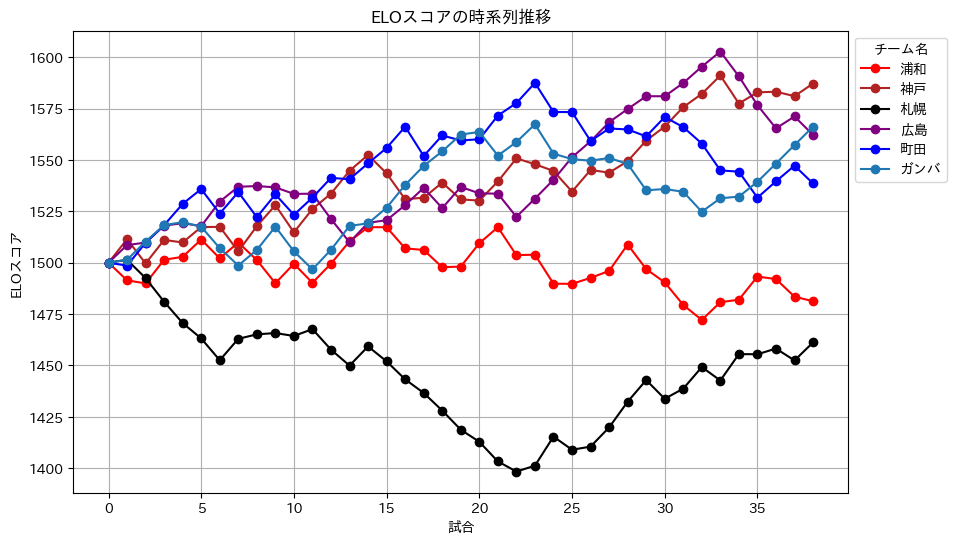

In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.figure(figsize=(10,6))
# for team, scores in elo_history.items():
#   plt.plot(range(len(scores)), scores, label=team, marker='o')

urawa_elo = elo_history['浦和']
kobe_elo = elo_history['神戸']
sapp_elo = elo_history['札幌']
hiro_elo = elo_history['広島']
machi_elo = elo_history['町田']
gosaka_elo = elo_history['Ｇ大阪']

plt.plot(range(len(urawa_elo)), urawa_elo, label='浦和', marker='o', color='red')
plt.plot(range(len(kobe_elo)), kobe_elo, label='神戸', marker='o', color='firebrick')
plt.plot(range(len(sapp_elo)), sapp_elo, label='札幌', marker='o', color='black')
plt.plot(range(len(hiro_elo)), hiro_elo, label='広島', marker='o', color='purple')
plt.plot(range(len(machi_elo)), machi_elo, label='町田', marker='o', color='blue')
plt.plot(range(len(gosaka_elo)), gosaka_elo, label='ガンバ', marker='o',)

# for i, score in enumerate(urawa_elo):
#   plt.text(i, score, urawa_vs[i])

plt.title("ELOスコアの時系列推移")
plt.xlabel("試合")
plt.ylabel("ELOスコア")
plt.legend(title="チーム名", loc='upper left', bbox_to_anchor=(1,1))
plt.grid()
plt.show()